**t-SNE (t-distributed Stochastic Neighbor Embedding) $-$ Стохастическое вложение соседей с t-распределением.**

**t-SNE** $—$ техника нелинейного снижения размерности и визуализации многомерных переменных, хорошо подходящая для вложения данных высокой размерности для визуализации в пространство низкой размерности (двух- или трехмерное). В частности, метод моделирует каждый объект высокой размерности двух- или трёхмерной точкой таким образом, что похожие объекты моделируются близко расположенными точками, а непохожие точки моделируются с большой вероятностью точками, далеко друг от друга отстоящими.

Алгоритм t-SNE состоит из двух главных шагов. Сначала t-SNE создаёт распределение вероятностей по парам объектов высокой размерности таким образом, что похожие объекты будут выбраны с большой вероятностью, в то время как вероятность выбора непохожих точек будет мала. Затем t-SNE определяет похожее распределение вероятностей по точкам в пространстве малой размерности и минимизирует расстояние Кульбака — Лейблера между двумя распределениями с учётом положения точек.

**Постановка задачи:**


Визуализируем с помощью t-SNE изображения, обработанные методом главных компонент (PCA).

**Описание структуры исходных данных:**

Датасет представляет собой изображения земли США, сделанные с воздуха. Каждое изображение было уменьшено до размера 28x28 пикселей.

Training и test лейблы зашифрованы в унитарном векторе 1x6. 

Каждый класс лейбла соответствует одному из шести типов широкого покрытия земли: barren land (голая земля), trees (деревья - лес), grassland (пастбище), roads (дороги), buildings (здания), water (вода).


Training и test наборы данных представляют собой набор изображений, случайно перемешанных ГПСЧ после генерации.

**Описание используемых функций и их параметров:**


pandas.DataFrame - двумерная неоднородная табличная форма представления данных.
> - первый параметр всегда исходные данные 
> - columns - лейблы колонок

sklearn.decomposition.PCA - метод главных компонент
> - n_components - количество компонент

sklearn.manifold.TSNE - Стохастическое вложение соседей с t-распределением.
> - n_components - размер пространства
> - verbose - многословный вывод
> - perplexity - количество ближайших соседенй, используемых в других обучающих алгоритмах
> - n_iter - количество итераций

**Решение задачи:**

In [1]:
import os
import csv
import numpy as np

Загружаем и читаем из репозитория необходимые нам файлы, а именно:

1. sat6annotations.csv: имена классов

2. X_train_subset.csv: поднабор X_train (т.е. изображения)

3. y_train_subset.csv: поднабор y_train (т.е. лейблы X_train изображений)

In [2]:
!rm -rf ELSI-DL-Bootcamp
!git clone https://github.com/Machine-Learning-Tokyo/ELSI-DL-Bootcamp.git

Cloning into 'ELSI-DL-Bootcamp'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Unpacking objects: 100% (97/97), done.


In [4]:
import pandas as pd
X_train = pd.read_csv('./ELSI-DL-Bootcamp/X_train_subset.csv', header=None)
y_train = pd.read_csv('./ELSI-DL-Bootcamp/y_train_subset.csv', header=None)
class_names = list(pd.read_csv('./ELSI-DL-Bootcamp/sat6annotations.csv', header=None)[0])

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Class names: {}".format(class_names))

Shape of X_train: (3000, 3136)
Shape of y_train: (3000, 6)
Class names: ['building', 'barren_land', 'trees', 'grassland', 'road', 'water']


Категоризируем лейблы для визуальной согласованности.

In [6]:
feat_cols = ['pixel'+str(i) for i in range(X_train.shape[1])]
df = pd.DataFrame(X_train.values, columns=feat_cols)

labels = []
numeric_labels = []
for _, cols in y_train.iterrows():
    labels.append(class_names[np.argmax(cols.to_list())])
    numeric_labels.append(np.argmax(cols.to_list()))


df['y'] = labels
df['numeric_label'] = numeric_labels

In [18]:
#Количество изображений каждого из классов
for label_name in class_names:
  print("{}: {}".format(label_name, labels.count(label_name)))

building: 147
barren_land: 659
trees: 526
grassland: 495
road: 62
water: 1111


**Визуализация результата:**

In [8]:
#Догружаем библиотеки для визуализации и работы с PCA и t-SNE
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import time

Для воспроизводимости результата выставляем значения случаной последовательности.

In [9]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

Обрабатываем данные методом главных компонент (с тремя главными компонентами). PCA использует корреляцию между пространствами и пытается предоставить минимальное количество переменных, сохраняющее максимальное число вариации или информации о том, какое количество исходных данных мы распределили.

In [10]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

#по колонке для каждого из количества компонент в методе
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.65892326 0.17176854 0.01565496]


Результаты таковы:

> - Первая главная компонента PCA (первое пространство сжатых данных) имеет максимальную вариацию, равную: 0.65892326
> - Вторая главная компонента PCA (второе пространство сжатых данных) имеет максимальную вариацию, равную: 0.17176854
> - Третья главная компонента PCA (третье пространство сжатых данных) имеет максимальную вариацию, равную: 0.01565496

Это означает следующее:

> - мы сохранили 84% информации исходных данных (изображений)
> - когда мы описываем данные в трёх пространствах, мы теряем 16% информации
> - когда же мы работаем с двумя пространствами, мы теряем 17.5% информации

Text(0.5, 1.0, 'First two dimensions of PCA-compressed-data')

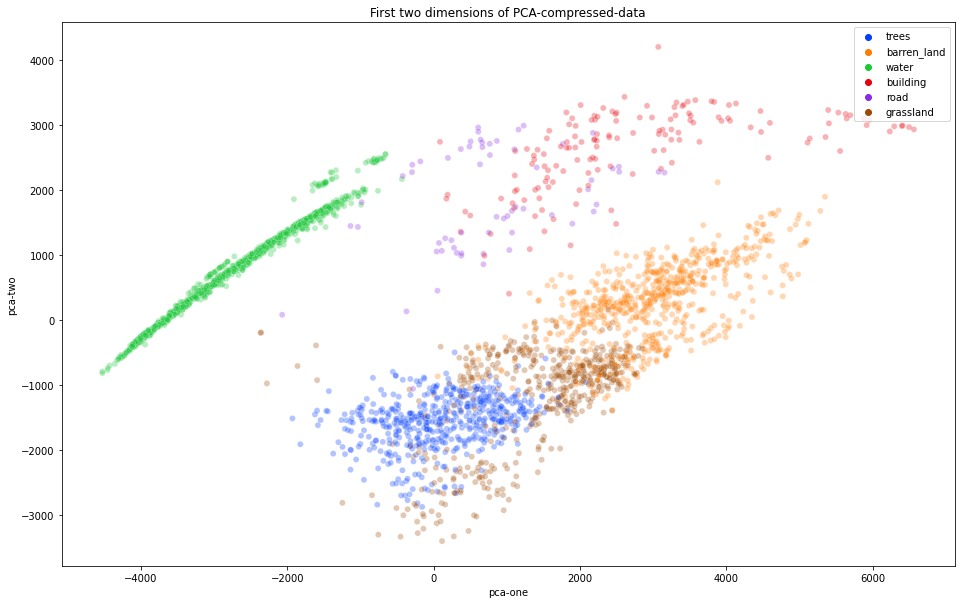

In [11]:
#Визуализируем первое и второе пространство сжатых данных
plt.figure(figsize=(16,10))
g_pca_2d = sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("bright", 6),
    data=df.loc[:,:],
    legend="full",
    alpha=0.3
)

g_pca_2d.legend(loc='upper right')
g_pca_2d.set_title("First two dimensions of PCA-compressed-data")

**Используем t-SNE на сжатых PCA данных:**

Трансформируем данные и визуализируем t-SNE в 2D, используя scatterplot.

In [19]:
df_subset = df.loc[rndperm,:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 178.282540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.238274
[t-SNE] KL divergence after 300 iterations: 0.985993
t-SNE done! Time elapsed: 6.801312685012817 seconds


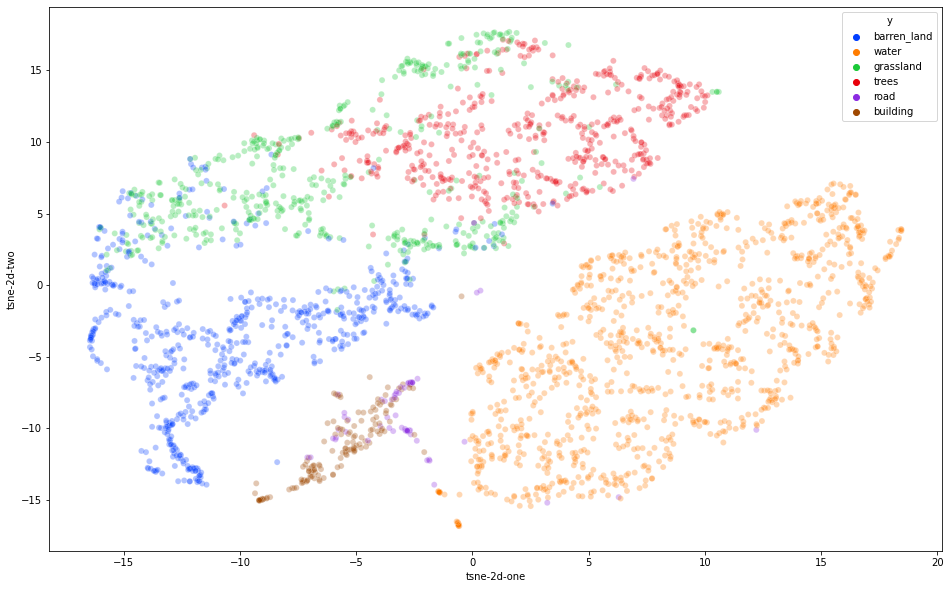

In [20]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("bright", 6),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Рассмотрим случай работы с пятью компонентами.

In [21]:
pca_5 = PCA(n_components=5)
pca_result_5 = pca_5.fit_transform(data_subset)
print('Explained variation for 5 principal components: {}'.format(pca_5.explained_variance_ratio_))
print('Cumulative explained variation for 5 principal components: {}'.format(np.sum(pca_5.explained_variance_ratio_)))

Explained variation for 5 principal components: [0.65892326 0.17176854 0.01565496 0.00871125 0.00635331]
Cumulative explained variation for 5 principal components: 0.8614113193261206


In [22]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_5)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 6.836296796798706 seconds


Сравним все три полученных результата:

1. PCA (с тремя главными компонентами и сразу же визуализированное)

2. t-SNE (t-SNE испольванное на сжатых PCA данных с тремя главными компонентами) в 2D

3. t-SNE (t-SNE испольванное на сжатых PCA данных с пятью главными компонентами) в 2D

Text(0.5, 1.0, 't-SNE plot of PCA (compressed into 5 dimensions)')

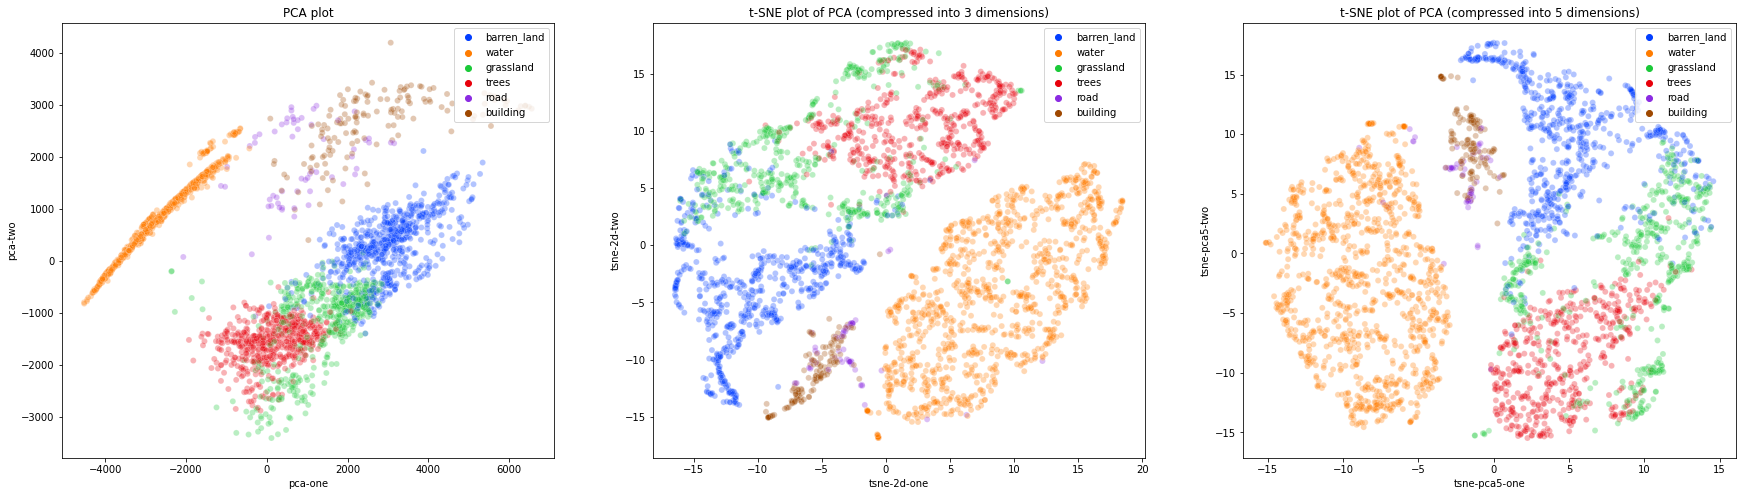

In [23]:
df_subset['tsne-pca5-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca5-two'] = tsne_pca_results[:,1]


plt.figure(figsize=(30,8))
ax1 = plt.subplot(1, 3, 1)
g1 = sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("bright", 6),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
g2 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("bright", 6),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
g3 = sns.scatterplot(
    x="tsne-pca5-one", y="tsne-pca5-two",
    hue="y",
    palette=sns.color_palette("bright", 6),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

g1.legend(loc='upper right')
g1.set_title("PCA plot")
g2.legend(loc='upper right')
g2.set_title("t-SNE plot of PCA (compressed into 3 dimensions)")
g3.legend(loc='upper right')
g3.set_title("t-SNE plot of PCA (compressed into 5 dimensions)")


**Интерпретация результата:**

Использование t-SNE лучше сохраняет структуру и закономерность исходных данных. При работе с пятью главными компонентами удалось сохранить 86.14% информации изображений, что на 2.14% больше, чем при трех компонентах. 

**Задания для самостоятельной работы:**

- На плоскости расположены три точки, $A = (0; 0)$, $B = (3; 4)$  и  $C = (6; 0)$. Джеймс Бонд
равновероятно забрасывается в одну из трёх точек. Затем Джеймс Бонд перемещается в одну
из оставшихся точек, чтобы спутать следы. Вероятность перемещения из точки заброски
$Z$ в точку $X$ пропорциональна $f(d)$, где $d$ — расстояние от точки заброски $Z$ до точки $X$,
а $f$ $—$ функция плотности нормального распределения $N(0; σ^2_Z
)$. Параметр $σ^2_Z$
— это сила,
оставшаяся у Джеймса-Бонда после заброски в точку $Z$.
Майор Пронин устроил засады на всех трёх дорогах: $AB$, $BC$ и $AC$.

  $1.$ Какова вероятность поимки Джеймса Бонда на каждой из дорог для $σ_A$ $=$ 1, $σ_A$ ⟶ 0, $σ_A$ ⟶ $∞$, если по последним разведданным он был заброшен в точку $A$?
  
  $2.$ Какие возможные значения принимает спутанность (perplexity) распределения выбираемой дороги при произвольных $σ_A$, если известно, что Джеймс Бонд был заброшен в $A$? Хватит ли у Джеймса Бонда сил, чтобы обеспечить спутанность равную $3$ в точке $A$?

  $3.$ Какие возможные значения принимает спутанность (perplexity) распределения выбираемой дороги при произвольных $σ_B$, если известно, что Джеймс Бонд был заброшен в $B$?

  $4.$ Найдите вероятность поимки Джеймса Бонда на каждой из дорог для случая равных
$σ_Z$: $σ_Z$ $=$ 1, $σ_Z$ ⟶ 0, $σ_Z$ ⟶ $∞$ и неизвестной точки заброски.